**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 9: Artificial Neural Networks and Optimization

**Content:**
- Part 1: What is a neural network?
- Part 2: A primer on gradient-based optimization
- Part 3: Training a simple neural network 
- Part 4: Regression with a neural network
- Part 5: Multinomial classification with a neural network

**Objectives:**
- Get a feeling of how artificial neural networks (ANN) can be used for data modelling and the role of hidden units in neural networks.
- Understand how ANNs are trained using gradient-based optimization.
- Understand how ANNs and multinomial regression (the generalization of logistic regression to multiple classes) can be applied to multi-class problems.

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

def get_grid_points(x_min, x_max, y_min, y_max, delta=5e-3):
    # Create a grid of points with the specified resolution
    xx = np.arange(x_min, x_max, delta)
    yy = np.arange(y_min, y_max, delta)
    # Make a mesh-grid that spans the grid-range defined
    grid = np.stack(np.meshgrid(xx, yy))
    return grid, xx, yy

def plot_decision_boundary(predict_function, X, threshold=None, fig=None, cmap='RdBu_r'):
    # Set grid range based on the data
    grid_range = [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()]  # [x_min, x_max, y_min, y_max]
    # Add 10% margin to the grid range to ensure points on the edge are included
    margin_x = 0.1 * (grid_range[1] - grid_range[0])
    margin_y = 0.1 * (grid_range[3] - grid_range[2])
    grid_range[0] -= margin_x
    grid_range[1] += margin_x
    grid_range[2] -= margin_y
    grid_range[3] += margin_y

    # Get grid points
    grid, xx, yy = get_grid_points(*grid_range, delta=5e-3)
    # Reshape grid to a list of points
    grid_points = torch.tensor(np.reshape(grid, (2, -1)).T, dtype=torch.float32)

    # Compute model predictions on the grid points (i.e. the probability of class 1)
    with torch.no_grad():  # No need to compute gradients for plotting
        grid_predictions = predict_function(grid_points)

    # Reshape the predictions back to the grid shape
    decision_boundary = np.reshape(grid_predictions, (len(yy), len(xx)))

    # Setup figure and axis for plotting
    if fig is None:
        fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    # Plot the decision boundary
    img = ax.imshow(decision_boundary, extent=grid_range, origin='lower', cmap=cmap, alpha=0.5)
    fig.colorbar(img, ax=ax)
    if threshold is not None:
        ax.contour(grid[0], grid[1], decision_boundary, levels=[threshold], colors='k')
    ax.grid(False)
    ax.set_aspect('auto')

## Introduction

In this week’s exercise, we will first introduce what a neural network is, then highlight why we need gradient-based optimization for training it. Later we will apply gradient-based optimization to train an ANN for a simple supervised learning task and finally explore applications of ANNs to real-world regression and multi-class classification problems.


---
## Part 1: What is a neural network?

An artificial neural network is a flexible function that you can train to learn a specific task. You can think of it with an example as follows:

You want to learn how to cook a good ramen (**train the network**) such that it matches the one from your favorite ramen restaurant (**the target function**). Initially, you randomly mix the ingredients (**input data**) by some amount of each ingredient (**the parameters/weights**), and you end up with a weird tasting dish (**the output**). You then compare it to the ramen from the restaurant (**compute the loss**) which gives you an idea on *how to adjust the amount of each ingredient* (**the gradient**) to make it taste the same. From this, you update your recipe and repeat the steps until the ramen has the right taste (**gradient descent**).

In other words, a neural network is a flexible function, $f\left(\cdot, \boldsymbol{w} \right)$, that takes some input data $\boldsymbol{x} \in \mathbb{R}^M$ and gives predictions $\hat{\boldsymbol{y}} = f(\boldsymbol{x}, \boldsymbol{w})$ depending on the setting of its parameters $\boldsymbol{w}$. The "recipe" takes the form of a structured computational graph. In the figure below we show a 1-layer neural network that takes an input data point $\boldsymbol{x}=\begin{bmatrix}x_1, x_2 \end{bmatrix}^\top$ and makes a prediction $\hat{y}$ through a hidden layer where the data is represented as $\boldsymbol{z}^{(1)} = \begin{bmatrix} z_1^{(1)}, z_2^{(1)} \end{bmatrix}^\top$.

<p align="center">
  <img src="nn.png" alt="Neural network example" height="400px">
</p>

Mathematically, a **neural network is a non-linear function** where the predicted output can be written as:
$$
    \hat{y} = f\left(\boldsymbol{x}, \boldsymbol{w}\right) = h^{(2)} \left( \left(\underset{=\boldsymbol{z}^{(1)}}{\underbrace{h^{(1)}\left(\boldsymbol{W}^{(1)} \boldsymbol{x} + \boldsymbol{b}\right)}}\right)^\top \boldsymbol{w}^{(2)} + b^{(2)} \right)
$$
where we use the following notation:
- $\boldsymbol{w}=\{\boldsymbol{W}^{\left(1\right)}, \boldsymbol{b}^{\left(1\right)}, \boldsymbol{w}^{\left(2\right)}, b^{\left(2\right)}\}$ is the collection of all weights and biases.
- $\boldsymbol{W}^{(1)} = \begin{bmatrix} \color{teal}{\boldsymbol{w}_1^{(1)}}, \color{orange}{\boldsymbol{w}_2^{(1)}} \end{bmatrix} = \begin{bmatrix} \color{teal}{w_{11}^{(1)}} & \color{orange}{w_{21}^{(1)}} \\ \color{teal}{w_{12}^{(1)}} & \color{orange}{w_{22}^{(1)}} \end{bmatrix}$ are the input layer weights and $\boldsymbol{b}^{(1)}=\begin{bmatrix} \color{teal}{b_1^{(1)}} \\ \color{orange}{b_2^{(1)}} \end{bmatrix}$ are the input layer biases. 
- $\color{violet}{\boldsymbol{w}^{(2)}}=\begin{bmatrix} w_1^{(2)} \\ w_2^{(2)}\end{bmatrix}$ are the output layer weights and $\color{violet}{b^{(2)}}$ is the output layer bias.
- $h^{(1)}$ and $h^{(2)}$ are the *activation functions* (or transfer functions) for each layer, depicted above the nodes. Concretely, $h^{(1)}\left(\boldsymbol{x}\right) := \max\left(0, \boldsymbol{x}\right)$ is the non-linear ReLU activation and $h^{(2)}$ is the linear function that does not change what is inputted to it. 

We chose to write the weights of each layer by $\boldsymbol{W}^{(l)}$ where the superscript $l$ denotes the layer index. This is because we are free to increase the number of *neurons/hidden units* per layer as well as the number of layers when we define a neural network, which is exactly what makes the neural network highly flexible. In fact, the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) tells us that a 1-layer neural network with infinitely many hidden units can approximate any function! 

**Task 1.1:** How many parameters does the network have? How would this change if the hidden layer had 10 units?

> *Hint:* First, you can simply count the number of weights and biases on the figure.

> *Hint:* For the second question, think about how the weights for each input dimension changes, i.e. how many elements will $\color{teal}{\boldsymbol{w}_1^{(1)}}$ and $\color{orange}{\boldsymbol{w}_2^{(1)}}$ contain when increasing the number of units? What happens to $\boldsymbol{b}^{\left(1\right)}$?

> *Hint:* Remember to also consider what happens to $\color{violet}{\boldsymbol{w}^{(2)}}$. Does the dimensionality of $\color{violet}{b^{\left(2\right)}}$ change?

**Task 1.2:** Using pen and paper, compute $f_{\boldsymbol{w}}\left(\boldsymbol{x}=\begin{bmatrix} 1 \\ 1\end{bmatrix}\right)$, i.e. the predicted output of the above neural network. Use the following configurations:
$$
    \color{teal}{\boldsymbol{w}_1^{(1)}} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad \color{orange}{\boldsymbol{w}_2^{(1)}} =  \begin{bmatrix} 1 \\ 6 \end{bmatrix}, \quad \color{violet}{\boldsymbol{w}^{(2)}} = \begin{bmatrix} -1 \\ 1 \end{bmatrix} 
$$
$$
    b^{(1)} = \begin{bmatrix} 1 \\ -2\end{bmatrix}, \quad b^{(2)} = 4
$$

**Task 1.3:** If there instead is only one unit in the hidden layer and in the output layer, and the activation function of each layer is linear, the neural network is the same as a simple model that we have seen previously in the course. Can you figure out which?

Linear Regression (Regression model)

> *Hint:* If you don't know how to start, consider drawing the network and adjust the function $f_{\boldsymbol{w}}$ above accordingly.

> *Hint:* The formula should be similar to something you have seen before. If you don't know where, check week 5.

**Task 1.4:** What happens if you change the output activation function to the sigmoid function?

Logistic Regression (classification model)

> *Hint:* Repeat the steps from task 1.2.


---
## Part 2: A primer on gradient-based optimization

In machine learning, we often work with a data-dependent parametric model, which can be written mathematically as:
$$
f : \mathbb{R}^M \rightarrow \mathbb{R}^D.
$$
Given a dataset of $\left(\boldsymbol{X}, \boldsymbol{y}\right)$, we can compute the loss $E(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w})$ that measures how well the model’s predictions $\hat{\boldsymbol{y}}=f\left(\boldsymbol{x}, \boldsymbol{w}\right)$ match the observed targets $\boldsymbol{y}$. For finding the optimal model parameters, we solve an **optimization problem**:
$$
\boldsymbol{w}^\ast = \arg \min_{\boldsymbol{w}} E(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}),
$$
where $\boldsymbol{w}^\ast$ is the parameter setting that best aligns predictions with the observed data. In week 5 we solved the optimization problem for linear regression using the mean squared error (MSE) as the loss function. As linear regression is indeed a linear model, we were able to get a closed-form expression for the optimal model parameters. 

For neural networks, the optimization problem does not have a closed-form solution due to the non-linearities of the network. Instead we iteratively estimate the optimal parameters $\boldsymbol{w}^\ast$ using **gradient descent** which proceeds as follows:
1. Initialize the parameter estimate as $\boldsymbol{w}^{\left(0\right)}$ and choose the learning rate $\alpha$
2. At each time step $t\in[1, \dots T]$ we:
    - compute the gradient of the loss wrt. $\boldsymbol{w}$, i.e. $\nabla_{\boldsymbol{w}} E \left(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}^{\left(t-1\right)} \right)$
    - update the parameter estimate as $\boldsymbol{w}^{\left(t\right)} \leftarrow \boldsymbol{w}^{\left(t-1\right)} - \alpha \cdot \nabla_{\boldsymbol{w}} E \left(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}^{\left(t-1\right)} \right)$
3. Use $\boldsymbol{w}^\ast = \boldsymbol{w}_T$ as the optimal parameter estimate.

Recall that the gradient is a vector with the partial derivatives of the function $E$, i.e. $\nabla_{\boldsymbol{w}} E = \begin{bmatrix} \frac{\partial E}{\partial w_1}, \frac{\partial E}{\partial w_2}, \dots, \frac{\partial E}{\partial w_K} \end{bmatrix}^\top$. It describes the direction from $\boldsymbol{w}$ where the loss function changes the most. In gradient descent we step-wise approach a minimum of the function by stepping opposite to the gradient where the learning rate $\alpha$ controls the speed and stability of the algorithm.

**Task 2.1:** Consider the simple loss function that only depends on one parameter, i.e. $E\left(w\right) = w^4 - w^2 + \frac{1}{4}w$. Derive an expression of the gradient using pen-and-paper.

> *Hint:* You only have one parameter, so the gradient is just the derivative of $E$ wrt. $w$.

**Task 2.2:** Implement the gradient descent scheme from above and run it for $T=4$ steps with a learning rate of $\alpha=0.01$. Start from $w_0=1.5$ and store the trajectory in a list.

> *Hint:* Use a `for`-loop to run gradient descent for $T=4$ steps.

> *Hint:* To store the parameter trajectory use `.append` on the list, e.g. `trajectory.append(wt)` where `wt` is the estimate at time $t$.

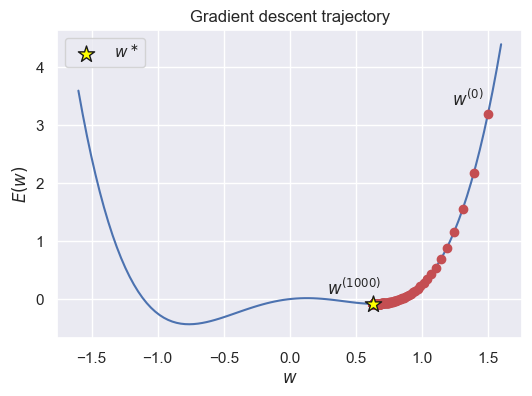

In [25]:
w0 = 1.5
n_steps = 1000
learning_rate = 0.01

trajectory = [w0]
wt = w0
for step in range(n_steps):
    wt = wt - learning_rate * (4 * wt**3 - 2 * wt + 1/4)
    trajectory.append(wt)

# Define the loss function
loss_function = lambda w: w**4 - w**2 + 1/4 * w 

# Compute the loss function values for a range of w values
ws = np.linspace(-1.6, 1.6, 100)

# Plot the loss function and the trajectory of gradient descent
fig = plt.figure(figsize=(6, 4))
plt.plot(ws, loss_function(ws), zorder=1)
# Plot the trajectory points
for t, w in enumerate(trajectory):
    plt.plot(w, loss_function(w), 'ro', zorder=2)
    if n_steps < 5 or t == 0 or t == n_steps:
        plt.text(w - 0.15, loss_function(w) + 0.15, f'$w^{{({t})}}$', ha='center')

plt.scatter(trajectory[-1], loss_function(trajectory[-1]), s=150, marker='*', color='yellow', edgecolors='k', label=r'$w^\ast$', zorder=3)
plt.title('Gradient descent trajectory')
plt.xlabel(r'$w$')
plt.ylabel(r'$E(w)$')
plt.legend()
plt.show()

**Task 2.3:** Try to experiment with the number of steps by increasing it to $T=100$. How does this impact the estimate of $w^\ast$? 

Chaning T alone get us stuck in local minima.

> *Hint:* Do you reach the local or the global minima?

**Task 2.4:** Try to experiment with the learning rate $\alpha$. What happens if you decrease it to $\alpha=0.001$? Or increase it to $\alpha=0.15$? For both cases, explain why.

Decreasing alpha gets us stuck in local minima because the step is not large enough to overcome the hill. On the other hand, with alpha 0.15, the initial step takes us beyond the first hill and ends up in the 'global minima valley'.

> *Hint:* In which of the cases do you reach the global minima instead of the local minima? 

A common method for speeding up convergence as well as helping prevent getting stuck in local minima is to add *momentum* to the gradient descent update. The concept is similar to a ball rolling down a hill with some momentum from its previous location. Mathematically, gradient descent with momentum is:

1. Initialize the parameter estimate as $\boldsymbol{w}^{\left(0\right)}$ and update vector $\boldsymbol{v}^{\left(0\right)}$. Choose the learning rate $\alpha$.
2. At each time step $t\in[1, \dots T]$ we:
    - compute the gradient of the loss wrt. $\boldsymbol{w}$, i.e. $\nabla_{\boldsymbol{w}} E \left(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}^{\left(t-1\right)} \right)$
    - compute the update with momentum as $ \boldsymbol{v}^{\left(t\right)} = \beta \cdot \boldsymbol{v}^{\left(t-1\right)} - \alpha \cdot \nabla_{\boldsymbol{w}} E \left(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w}^{\left(t-1\right)} \right)$
    - update the parameter estimate as $\boldsymbol{w}^{\left(t\right)} \leftarrow \boldsymbol{w}^{\left(t-1\right)} + \boldsymbol{v}^{\left(t\right)}$
3. Use $\boldsymbol{w}^\ast = \boldsymbol{w}_T$ as the optimal parameter estimate.

**Task 2.5 (Optional):** Implement the gradient descent with momentum. Set the momentum parameter to $\beta=0.9$ and the learning rate to $\alpha=0.01$. What happens to the size of the first 5 update steps? Is the final solution a global or local minima?

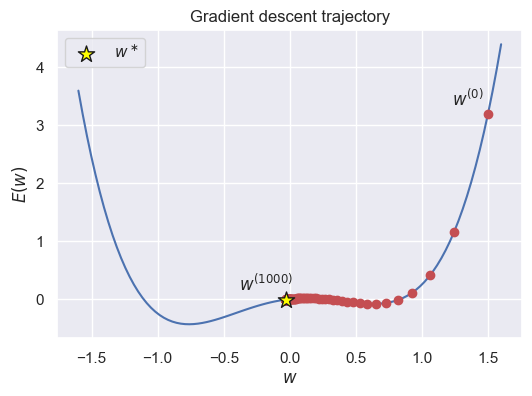

In [24]:
w0 = 1.5
n_steps = 1000
learning_rate = 0.01
momentum = 0.9

trajectory = [w0]
wt = w0
for t in range(n_steps):
    grad = 4 * wt**3 - 2 * wt + 1/4
    wt = momentum * wt - learning_rate*grad
    trajectory.append(wt)

# Define the loss function
loss_function = lambda w: w**4 - w**2 + 1/4 * w 

# Compute the loss function values for a range of w values
ws = np.linspace(-1.6, 1.6, 100)

# Plot the loss function and the trajectory of gradient descent
fig = plt.figure(figsize=(6, 4))
plt.plot(ws, loss_function(ws), zorder=1)
# Plot the trajectory points
for t, w in enumerate(trajectory):
    plt.plot(w, loss_function(w), 'ro', zorder=2)
    if n_steps < 5 or t == 0 or t == n_steps:
        plt.text(w - 0.15, loss_function(w) + 0.15, f'$w^{{({t})}}$', ha='center')

plt.scatter(trajectory[-1], loss_function(trajectory[-1]), s=150, marker='*', color='yellow', edgecolors='k', label=r'$w^\ast$', zorder=3)
plt.title('Gradient descent trajectory')
plt.xlabel(r'$w$')
plt.ylabel(r'$E(w)$')
plt.legend()
plt.show()

In the above example, we considered a 1-dimensional parameter space so the gradient was just the scalar derivative. To complete the introduction to gradient descent, we now consider a function with a 2-dimensional parameter space where $\boldsymbol{w} = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}$. We choose the loss as $E(\boldsymbol{w}) = \boldsymbol{w}^\top \mathbf{\Sigma} \boldsymbol{w}$ where $\mathbf{\Sigma}=\begin{bmatrix} 1.0 & 0.1 \\ 0.1 & 0.5 \end{bmatrix}$.

**Task 2.6:** Write out the loss explicitly as a function containing $w_1$ and $w_2$. Implement it as a loss function similarly to the previous exercise.

> *Hint:* Write out the matrix-vector product.

**Task 2.7:** Using pen and paper, write down the gradient which is now a vector. Adjust your gradient descent implementation to work with vectors in the 2D case.

> *Hint:* Remember the definition of the gradient. Construct it as a vector using `np.array()`.

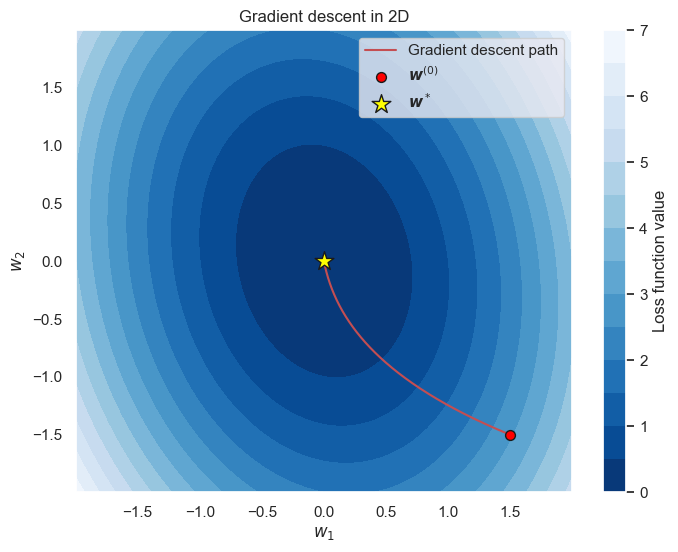

In [26]:
# Define a 2D loss function that depends on two coordinates
loss_function = lambda coordinates: coordinates[:, 0]**2 + 0.2*coordinates[:, 0]*coordinates[:, 1] + 0.5*coordinates[:, 1]**2

# Set the number of steps and learning rate
num_steps = 1000
learning_rate = 0.01

# Choose the initial point to start the gradient descent from
w0 = np.array([1.5, -1.5])
trajectory = [w0.flatten()]

# Run gradient descent
wt = w0
for i in range(num_steps):
    # Compute gradient of the loss function
    grad = np.array([2*wt[0] + 0.2*wt[1], 0.2*wt[0] + 1.0*wt[1]])
    wt = wt - learning_rate * grad
    trajectory.append(wt.flatten())

# Convert trajectory to a numpy array for easier indexing
trajectory = np.vstack(trajectory)

# Define the grid of points to evaluate the loss function for visualization
xmin, xmax, ymin, ymax = -2, 2, -2, 2
grid, xx, yy = get_grid_points(xmin, xmax, ymin, ymax, delta=5e-3)
grid_points = np.reshape(grid, (2, -1)).T

# Setup figure
fig = plt.figure(figsize=(8, 6))
# Plot the contour of the loss function
loss = plt.contourf(loss_function(grid_points).reshape(len(yy), len(xx)), cmap='Blues_r', levels=15, extent=(xmin, xmax, ymin, ymax), origin='lower')
# Plot the trajectory of gradient descent
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', label='Gradient descent path', zorder=2)
# Highlight the starting and ending points
plt.scatter(trajectory[0, 0], trajectory[0, 1], s=200, marker='.', color='red', edgecolors='k', label=r'$\boldsymbol{w}^{(0)}$', zorder=3)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], s=200, marker='*', color='yellow', edgecolors='k', label=r'$\boldsymbol{w}^*$', zorder=3)
plt.title('Gradient descent in 2D')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.colorbar(loss, label='Loss function value')
plt.legend()
plt.show()

We have now seen gradient descent for cases where we have few parameters and can visualize the loss function (also called the *loss landscape*). Even small neural networks like the one from Part 1 have more than 2 parameters which makes it impossible to visualize the loss landscape. However, the concept of gradient descent is exactly the same in neural networks where the parameter space is of higher than 2-dimensions. In the following, we will apply gradient descent to such networks without directly visualizing the gradient descent path in the parameter space. 


---
## Part 3: Training a simple neural network 

For constructing a neural network in practice, we will use an open source library called "Pytorch" (or `torch`). Pytorch supports running code on GPU (with CUDA) which can speed up computation time, however, we will only need to consider the CPU version in this course. If you are new to Pytorch, it can look complicated - so in the following exercises, we will do the setup for inspiration. 

We now have the basics covered and we can proceed with training a simple neural network similar to the one from Part 1. For doing so, we will consider an example that is highly visual, namely the `XOR` dataset. This dataset is made for binary classification.

**Task 3.1:** Read through the code cell below. Which method do we use for splitting `X_train`, `y_train`, `X_test` and `y_test`? What is the dimensionality of the input and output space? 

> *Hint:* The input space dimensionality is the number of features. If in doubt, writing `X_train.shape` might help you.

> *Hint:* For the output space dimensionality, use the same reasoning but for `y_train`.

> *Hint:* We need to transform the data to `torch` tensors to use it in Pytorch. This is another datatype than `numpy` arrays that simply speaking are multi-dimensional matrices. The way they are defined within PyTorch enables e.g. processing on GPUs, which speeds up training of large networks. We can define the inputs to be of a specific float type by specyfing the datatype: `dtype=torch.float32`.

> *Hint:* We use `torch.tensor(y_train).view(-1,1)` to make sure that the target is a column vector of shape $N\times 1$. What is the shape of `y_train` if you remove `.view(-1,1)`?

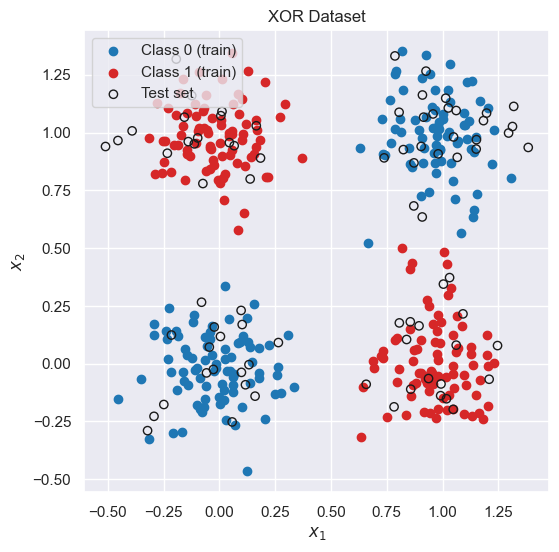

In [40]:
import torch # this is the Pytorch library

# Load the XOR dataset
df = pd.read_csv("data/xor.csv")

# Split the data into features and target
X = df[['x1', 'x2']].values
y = df['y'].values.astype(int)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define colors per class for plotting
colors = ['tab:blue', 'tab:red']

# Plot the XOR dataset
plt.figure(figsize=(6, 6))
for class_value in np.unique(y_train):
    # Create a mask for the current class
    mask = (y_train == class_value).flatten()
    # Plot training points
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {int(class_value)} (train)', color=colors[int(class_value)])

# Plot test points with a different marker (style)
plt.scatter(X_test[:, 0], X_test[:, 1], edgecolor='k', facecolors='none', label=f'Test set')
# Add labels and title
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('XOR Dataset')
plt.legend(loc='upper left')
plt.show()

**Task 3.2:** Construct the neural network from Part 1. Define three variables: `input_dim` which is the number of attributes in the data, `hidden_dim` which is the number of nodes in the hidden layer and `output_dim` which is the dimensionality of the target attribute.

> *Hint:* To define a neural network we use `torch.nn.Sequential`. Each argument to this function is a part of a sequentially applied network. We can get a layer that maps `M` features to `H` hidden units by using `torch.nn.Linear(M, H)`. We can then apply an activation function to the output of that layer by having the next argument be `torch.nn.ReLU()` or another activation function. To train a binary classifier, we need a suitable final activation function, which is for instance `torch.nn.Sigmoid()`.

In [44]:
import torch

input_dim = 2
hidden_dim = 100
output_dim = 1

# Define the neural network here. 
# We use define a function that returns a new instance of the model when called.
# This is useful for creating multiple instances of the model with the same or different number of hidden units.
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.ReLU(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
        torch.nn.Sigmoid(),                                                             # Output activation function (for binary classification)
    )

# Here we call a specific instance of the model
model = get_model(input_dim, hidden_dim, output_dim)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)


Since we are solving a binary classification task, we used the `Sigmoid` activation as the output. This restricts the output to be between 0 and 1, hence describing the probability of belonging to class 1. 

Next, we want to train the neural network to solve the binary classification task. We first define the loss (or the loss *criterion*) as the *binary cross-entropy* which is common for binary classification ([see here for further details](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/)). Then, we define an optimizer (here, gradient descent) that tells us how to iteratively minimize the loss function by updating the model parameters. We do that in the *training loop*.

**Task 3.3:** Read through the code below. Make sure you understand:
1) how the loss criterion is defined and computed, 
2) how we define *what* to optimize, 
3) how we use the training and test data specifically, 
4) where we compute the *gradient*,
5) how an *update* is made.

> *Hint:* To iteratively update the model parameters, we set `params=model.parameters()` in the optimizer. 

> *Hint:* Computing the gradient of a neural network wrt. its parameters is not straight-forward by hand. Instead we use something called *back-propagation* that uses the chain rule to automatically compute the gradient. You are not expected to know the technical details but if you are interested, [this video gives a good introduction to backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U). 

Epoch [1000/10000], Loss: 0.0712, Test Loss: 0.0625
Epoch [2000/10000], Loss: 0.0352, Test Loss: 0.0257
Epoch [3000/10000], Loss: 0.0251, Test Loss: 0.0159
Epoch [4000/10000], Loss: 0.0202, Test Loss: 0.0114
Epoch [5000/10000], Loss: 0.0173, Test Loss: 0.0089
Epoch [6000/10000], Loss: 0.0154, Test Loss: 0.0072
Epoch [7000/10000], Loss: 0.0139, Test Loss: 0.0061
Epoch [8000/10000], Loss: 0.0128, Test Loss: 0.0052
Epoch [9000/10000], Loss: 0.0120, Test Loss: 0.0045
Epoch [10000/10000], Loss: 0.0112, Test Loss: 0.0040


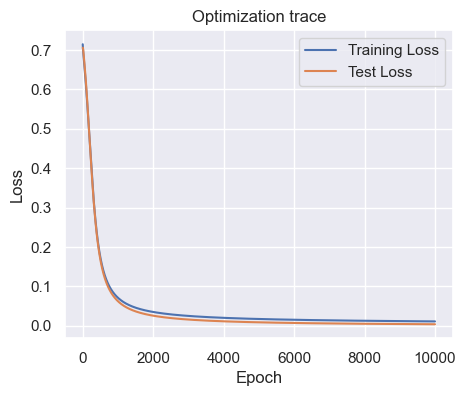

In [45]:
# Define a model instance with a specific number of hidden units
model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Define loss criterion
criterion = torch.nn.BCELoss()

# Define the learning rate for gradient descent
lr = 0.05
# Define the number of epochs (iterations over the entire dataset)
n_epochs = 10000

# Define the optimizer as stochastic gradient descent (SGD). 
# Here, the data is fixed, so it is equivalent to standard gradient descent.
# You define the parameters to optimize (the model parameters) by setting params=model.parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

# Define a dictionary to store the loss values for each epoch
results = {'train': [], 'test': []}

# Training loop
for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()
    # Make sure that the gradients are zero before you use backpropagation
    optimizer.zero_grad()

    # Make a forward pass through the model to compute the outputs
    outputs = model(X_train)
    # Compute the loss
    loss = criterion(outputs, y_train)
    # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
    loss.backward()

    # Update the model parameters by making the optimizer take a gradient descent step
    optimizer.step()

    with torch.no_grad(): # No need to compute gradients for the validation set
        # Set the model to evaluation mode
        model.eval()  
        # Compute the loss for the test set
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    
    # Store the training and test loss for this epoch in the dictionary
    results['train'].append(loss.item())
    results['test'].append(test_loss.item())

    # Print the loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot the optimization trace
fig = plt.figure(figsize=(5, 4))
plt.plot(results['train'], label='Training Loss')
plt.plot(results['test'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimization trace')
plt.legend()
plt.show()

Now, we have a trained neural network that we can use for predicting the labels of the test set. Though we used the binary cross entropy as the loss criterion, it is hard to interpret - a better alternative is to consider the model accuracy.

**Task 3.4:** Compute the predictions and accuracy of your model on the test set. Plot the predictions on top of the training data and print the accuracy score. How well does the model work on the test set and how can you see this from the decision boundary?

> *Hint:* First, you need to pass the test data through your trained model by `test_outputs = model(X_test)`.

> *Hint:* Since we used the sigmoid as the output activation, the outputs capture the probabilities of belonging to class 1. Use a threshold to convert the probability to class predictions, e.g. `y_pred = (test_outputs > 0.5).float()`.

> *Hint:* Compute the accuracy by checking how large a fraction of the predictions that are equal to the true label. One idea is to do `(y_pred == y_test).float().mean()`

> *Hint:* We provide you with a function for plotting the decision boundary that the model learned. It visualizes the probability of belonging to class 1.

> *Hint:* To plot the predictions, take inspiration from what we do when plotting the training points. Consider using `edgecolor='k'` in `plt.scatter()` to be able to distinguish the predicted points.

Accuracy on test set: 100.00%
Accuracy on test set: 100.00%


C:\Users\mrusn\AppData\Local\Temp\ipykernel_12620\1434399845.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx = np.arange(x_min, x_max, delta)
C:\Users\mrusn\AppData\Local\Temp\ipykernel_12620\1434399845.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  yy = np.arange(y_min, y_max, delta)


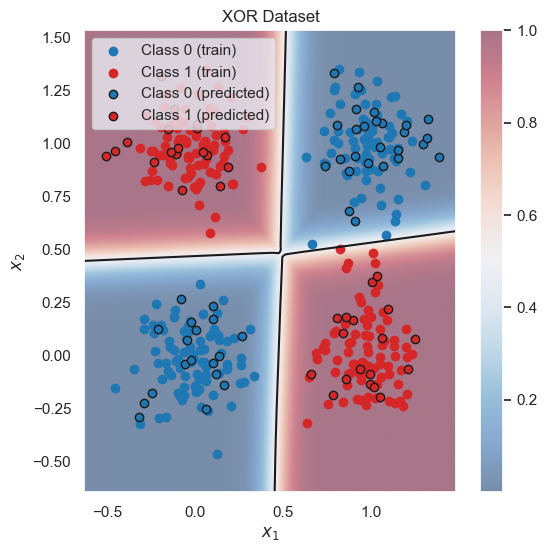

In [46]:
# COMPUTE PREDICTIONS AND ACCURACY ON THE TEST SET HERE

# Compute model outputs on the test set
test_outputs = model(X_test)
# Convert probabilities to class predictions
y_pred = (test_outputs > 0.5).float()

# Compute accuracy
accuracy = (y_pred == y_test).float().mean()
print(f'Accuracy on test set: {accuracy.item()*100:.2f}%')

# Compute accuracy
accuracy = (y_pred == y_test).float().mean()
print(f'Accuracy on test set: {accuracy.item()*100:.2f}%')

# Make a figure to plot the decision boundary and the data points
fig = plt.figure(figsize=(6, 6))
# Plot the decision boundary
plot_decision_boundary(predict_function=model, X=X_train, threshold=0.5, fig=fig)

for class_value in np.unique(y_train):
    # Create a mask for the current class
    mask = (y_train == class_value).flatten()
    # Plot training points
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {int(class_value)} (train)', color=colors[int(class_value)])

# PLOT THE PREDICTIONS HERE
for class_value in np.unique(y_pred):
    # Create a mask for the current predicted class
    mask = (y_pred == class_value).flatten()
    # Plot predicted test points
    plt.scatter(X_test[mask, 0], X_test[mask, 1], label=f'Class {int(class_value)} (predicted)', color=colors[int(class_value)], edgecolor='k')

# Add labels and title
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('XOR Dataset')
plt.legend(loc='upper left')
plt.show()

We can easily check the values of the optimal parameters found when running gradient descent above. We print these below: 

In [47]:
all_parameters = torch.cat([p.data.flatten() for p in model.parameters()])

print("Optimal parameters found by gradient descent:")
print(all_parameters)

Optimal parameters found by gradient descent:
tensor([ 2.2302e-01, -5.1494e-01,  4.9787e-01, -3.6353e-01,  2.1283e-01,
        -3.4087e-01,  5.1686e-01, -2.6755e-01,  1.5476e-01, -4.3010e-01,
        -5.1567e-01,  3.4511e-01, -1.0220e+00, -1.0873e+00, -3.5921e-01,
        -2.2852e-01, -8.4318e-02,  1.8998e-03, -2.5767e-01, -2.4573e-01,
        -1.2459e+00,  1.1593e+00,  4.0541e-01, -5.2602e-01, -3.0143e-01,
         4.3278e-01,  1.2212e-02,  1.2429e-02,  2.4029e-01, -2.9804e-01,
         1.9306e-01, -3.1695e-01, -2.7915e-01, -3.5923e-01,  9.6583e-01,
        -9.9381e-01, -5.0701e-01,  3.2369e-01,  4.2805e-01,  4.7819e-01,
        -8.4163e-01,  4.5044e-01,  3.0554e-02, -2.0275e-01, -9.2762e-01,
        -9.4756e-01, -3.9470e-01,  3.0336e-01,  9.4876e-02,  5.2005e-01,
        -3.7915e-01,  6.5942e-01, -3.6969e-01,  4.7556e-01, -4.9651e-01,
        -3.7965e-01,  2.4859e-01, -9.5902e-02, -1.6250e-01, -6.9508e-01,
        -9.9158e-01,  8.5022e-01, -2.1779e-01, -2.0086e-01, -2.7105e-01,
     

Note that you will get quite different results every time you run the script, since the loss function is *non-convex* and your results therefore depend on how the network was initialized (i.e. the random seed).

**Task 3.5:** Re-run the previous code cells and verify that the results change. 

> *Hint:* You should be able to see this on the optimization trace figure of the training and test loss, the decision boundary as well as on the optimal parameters that we just printed.

From repeating the experiment, you should see that the model with 2 hidden units often only obtains a test set accuracy of approximately 75% and that the decision boundary looks linear in many cases. 

**Task 3.6:** Go back and retrain a more flexible network by increasing the number of units in the hidden layer to 3 and 100. Argue why this gives a better model. What are the drawbacks of increasing the number of hidden units?

> *Hint:* Remember, that we can approximate *any* function by increasing the number of hidden units (universal approximation theorem).

- *Answer:*

**Task 3.8 (Optional):** What is the minimum number of hidden units that gives you a 100% accuracy on the test set? Can you explain why?

> *Hint:* Think about how many linear boundaries are needed to split the 2D plane into regions that separate the XOR data correctly.

Usually, we use crossvalidation to optimize hyperparameters (i.e. the learning rate and number of hidden units). You have seen how to do this in previous weeks and the concept is exactly the same here - the only change is the model type and what the hyperparameters are.

### Stochastic Gradient Descent

You might have remarked that the optimizer we used before was called `torch.optim.SGD`, where the S in fact stands for *stochastic*. In the previous example, we however considered a fixed loss function and indeed nothing was stochastic in that setting.

Stochastic gradient descent can be seen as an approximation of gradient descent - it replaces the actual gradient with an estimate of it. Specifically, remember that the loss is dependent on the specific dataset considered. Where normal gradient descent uses the entire data set to compute the loss and the gradient hereoff, stochastic gradient descent uses randomly selected subsets of the data to compute the gradient estimate. In high-dimensional optimization problems (e.g. large neural networks), this reduces the computational burden. 

**Task 3.9 (Optional):** Read through the code below. Make sure you understand where and how we compute the gradient estimate. What happens to the training loss?

> *Hint:* The training loss curve is not smooth anymore. Why do you think that is?

Epoch [1000/1000], Loss: 0.0112, Test Loss: 0.0039


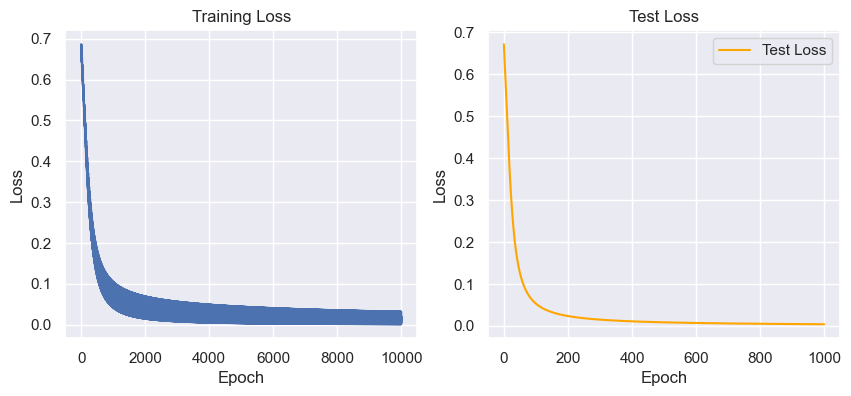

In [48]:
# Define a model instance with a specific number of hidden units
model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Define loss criterion
criterion = torch.nn.BCELoss()

# Define the learning rate for gradient descent
lr = 0.05
# Define the number of epochs (iterations over the entire dataset)
n_epochs = 1000

# Define batch size and number of batches
N_train = X_train.shape[0]
batch_size = 32
num_batches = N_train // batch_size

# Define the optimizer as stochastic gradient descent (SGD). 
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

# Define a dictionary to store the loss values for each epoch
results = {'train': [], 'test': []}

# Training loop
for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()

    # Shuffle the training data for doing stochastic gradient descent
    permutation_order = np.random.choice(np.arange(N_train), N_train, replace=False)                    
    # Loop over smaller batches of data
    for batch_idx in range(num_batches):
        X_train_batch = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size, :]
        y_train_batch = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size, :]

        # Make sure that the gradients are zero before you use backpropagation
        optimizer.zero_grad()

        # Make a forward pass through the model to compute the outputs
        outputs = model(X_train_batch)
        # Compute the loss for the batch
        loss = criterion(outputs, y_train_batch)
        # Do a backward pass to compute the gradient estimate wrt. model parameters using backpropagation.
        loss.backward()
        # Update the model parameters by making the optimizer take a gradient descent step
        optimizer.step()

        # Store the training loss for this epoch in the dictionary
        results['train'].append(loss.item())

    with torch.no_grad(): # No need to compute gradients for the validation set
        # Set the model to evaluation mode
        model.eval()  
        # Compute the loss for the test set
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        # Store the test loss for this epoch in the dictionary
        results['test'].append(test_loss.item())

    # Print the loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot the optimization trace
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(results['train'], label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(results['test'], label='Test Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Test Loss')

plt.legend()
plt.show()


---
## Part 4: Regression with a neural network

We can use ANNs for both classification and regression. When we train an ANN to do regression, we do not a apply a tranfer function to the output node(s), and we train the network using a mean-square-error loss. In the following, we will again consider the Wine dataset that we have worked with in previous weeks.

In the cell below, we load the data and construct the data matrix and target attribute. We will try to predict the alcohol content of each wine using a neural network for regression.

**Task 4.1:** Define the in- and output dimensions for the neural network.

In [71]:
df = pd.read_csv("data/wine.csv")

# Split the data into features and target
X = df.drop(columns=['Alcohol']).values
y = df['Alcohol'].values.reshape(-1, 1)

# Dimensionality of data
N, M = X.shape

input_dim = M
output_dim = 1

**Task 4.2:** Split the data into a test set and a training set using the holdout method such that 20% of the data is in the test set.

> *Hint:* Use `X, X_test, y, y_test = train_test_split(X, y, test_size=test_size, random_state=42)`. This definition of variables is important for the coming code cells to run.

In [72]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Task 4.3:** Define a one-layer neural network for regression in the function `get_model()`.

> *Hint:* What is the difference between a classification and regression model? You only need to remove one line of code from the previously defined function.

In [73]:
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.ReLU(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)    # Output layer                                                           # Output activation function (for binary classification)
    )

In the cell below, we provide a framework for training a neural network and doing hyperparameter optimization on the number of hidden units using one-level cross-validation. We leave some critical parts for you.

**Task 4.4:** Standardize the data within each cross-validation fold. Why is it important to do it within each fold?

> *Hint:* Remember that you have to subtract the mean and divide by the standard deviation for each attribute when doing standardization.

**Task 4.5:** Define the loss criterion.

> *Hint:* Remember that we usually use the mean squared error as the criterion for regression problems. This can be implemented as `torch.nn.MSELoss()`.

**Task 4.6:** Implement the training loop.

> *Hint:* Take inspiration from previous tasks.

> *Hint:* It is up to you whether you want to do gradient descent or stochastic gradient descent with batches.

Fold 1/3
  Hidden units: 1, Validation set MSE: 0.3440
  Hidden units: 2, Validation set MSE: 0.2711
  Hidden units: 10, Validation set MSE: 0.6255
  Hidden units: 50, Validation set MSE: 0.8113
Fold 2/3
  Hidden units: 1, Validation set MSE: 3.3408
  Hidden units: 2, Validation set MSE: 0.2553
  Hidden units: 10, Validation set MSE: 0.4674
  Hidden units: 50, Validation set MSE: 0.8779
Fold 3/3
  Hidden units: 1, Validation set MSE: 0.2696
  Hidden units: 2, Validation set MSE: 0.2965
  Hidden units: 10, Validation set MSE: 0.3806
  Hidden units: 50, Validation set MSE: 0.8095


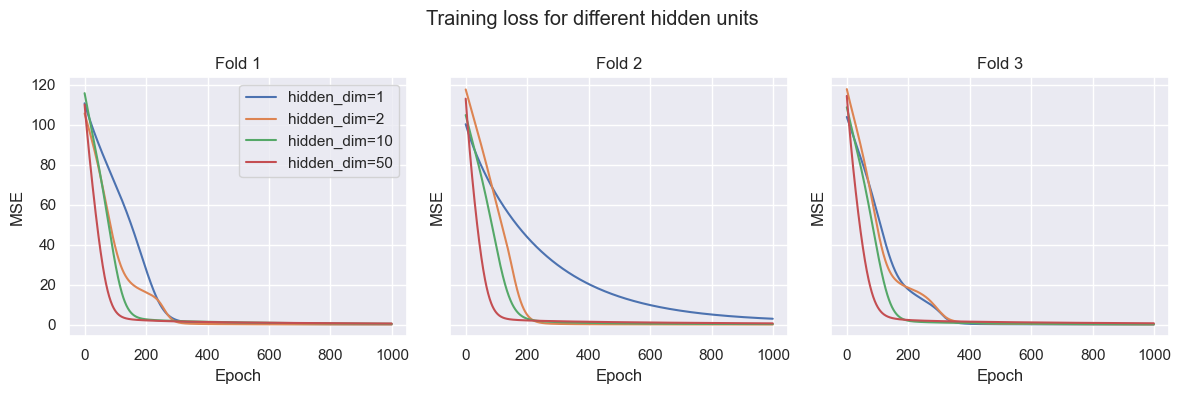

In [75]:

# K-fold crossvalidation
K = 3
CV = KFold(K, shuffle=True, random_state=0)

# Define hyperparameters
lr = 1e-3
n_epochs = 1000

# Seed for reproducibility
seed = 0

# Hyperparameter tuning loop with K-fold crossvalidation
hyperparameters_to_tune = [1, 2, 10, 50]

results = {}
for k, (train_index, val_index) in enumerate(CV.split(X, y)):
    print(f'Fold {k+1}/{K}')
    
    # Get the training and test data for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize data here
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # Set up a dictionary to store the results for each hyperparameter setting
    results_inner = {hidden_dim: {'train': [], 'val': []} for hidden_dim in hyperparameters_to_tune}

    # Loop over the hyperparameter settings        
    for hidden_dim in hyperparameters_to_tune:
        # Define a model instance with a specific number of hidden units
        model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        # Define loss criterion
        criterion = torch.nn.MSELoss()

        # Define the optimizer as the Adam optimizer (not needed to know the details)
        optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            # Set the model to training mode
            model.train()
            # Make sure that the gradients are zero before you use backpropagation
            optimizer.zero_grad()
        
            # Make a forward pass through the model to compute the outputs
            outputs = model(X_train)
            # Compute the loss
            loss = criterion(outputs, y_train)
            # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
            loss.backward()
        
            # Update the model parameters by making the optimizer take a gradient descent step
            optimizer.step()

            # Store the training loss for this epoch in the dictionary
            results_inner[hidden_dim]['train'].append(loss.item())

        # Compute the final test loss on the test set
        with torch.no_grad(): # No need to compute gradients for the validation set
            model.eval()
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            results_inner[hidden_dim]['val'].append(val_loss.item())
            print(f'  Hidden units: {hidden_dim}, Validation set MSE: {val_loss.item():.4f}')

    # Store the results for this fold
    results[k] = results_inner


# Plot the loss curves for each fold and hyperparameter setting
fig, axs = plt.subplots(1, K, figsize=(12, 4), sharey=True, sharex=True)
# Plot the training loss for each fold and hyperparameter setting
for fold in range(K):
    for hidden_dim in hyperparameters_to_tune:
        # Plot the training loss for this hyperparameter setting
        axs[fold].plot(results[fold][hidden_dim]['train'], label=f'hidden_dim={hidden_dim}')

    # Set the title and labels for each subplot
    axs[fold].set_title('Fold {}'.format(fold+1))
    axs[fold].set_xlabel('Epoch')
    axs[fold].set_ylabel('MSE')

# Set the overall title and show the legend
plt.suptitle('Training loss for different hidden units')
plt.tight_layout()
axs[0].legend()
plt.show()

**Task 4.7:** How many hidden units would you choose based on the results? Justify your answer.

> *Hint:* What are the pros and cons of increasing / decreasing the number of hidden units? How few number of units do you need to be able to interpret how the model uses the specific attributes in its output?

- *Answer:*

**Task 4.8:** We used gradient descent for optimizing the model. What happens to the results if you include momentum with $\beta=0.9$ to the optimizer?

> *Hint:* Add `momentum=0.9` as an input to the `torch.optim.SGD`-function.

When dealing with regression outputs, a simple way of looking at the quality of predictions visually is by plotting the estimated value as a function of the true/known value - these values should all be along a straight line "y=x", and if the points are above the line, the model overestimates, whereas if the points are below the y=x line, then the model underestimates the value

**Task 4.9:** Train a neural network with the optimal number of hidden units on all data except the held out part. Evaluate the performance of the model on the held out set `X_test` by computing the MSE and by plotting the predictions against the true targets `y_test`.

> *Hint:* Remember to do the same steps as we did above, i.e. normalization etc..

  Hidden units: 50, Test set MSE: 0.9056


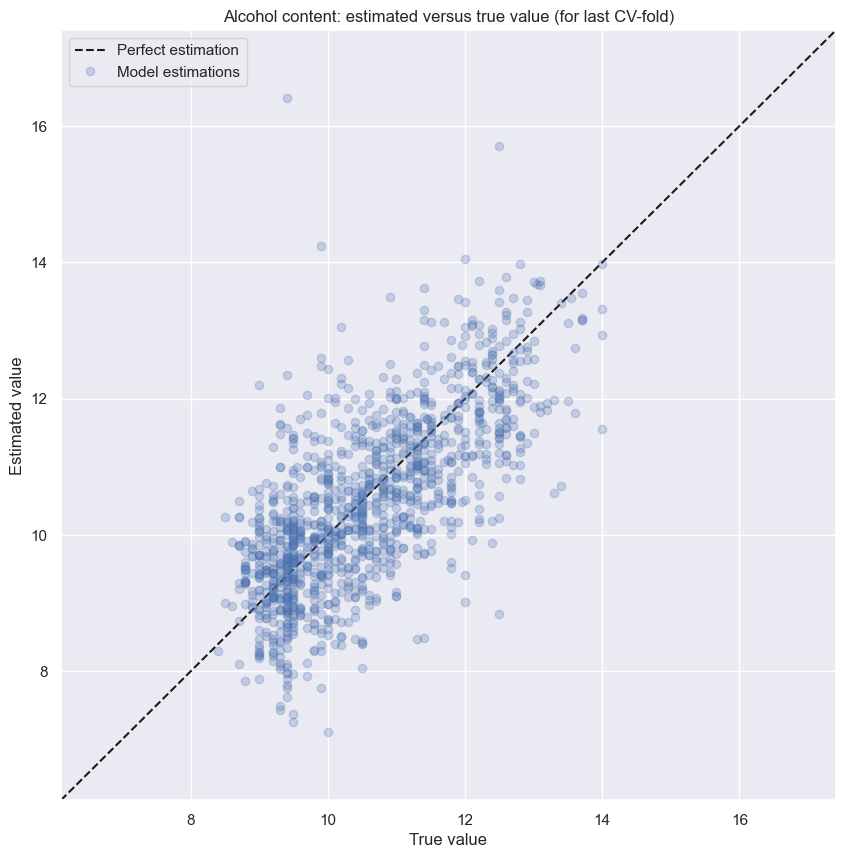

In [76]:
# YOUR CODE HERE
# Seed for reproducibility
seed = 0

# Define hyperparameters
lr = 1e-3
n_epochs = 1000
num_hidden_units = 50

# Normalize data here
mean, std = X.mean(axis=0), X.std(axis=0)
X_train = (X - mean) / std
X_test = (X_test - mean) / std

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define a model instance with a specific number of hidden units
model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
# Define loss criterion
criterion = torch.nn.MSELoss()
# Define the optimizer as the Adam optimizer (not needed to know the details)
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()

    # Make a forward pass through the model to compute the outputs
    outputs = model(X_train)
    # Compute the loss
    loss = criterion(outputs, y_train)

    # Make sure that the gradients are zero before you use backpropagation
    optimizer.zero_grad()
    # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
    loss.backward()
    # Update the model parameters by making the optimizer take a gradient descent step
    optimizer.step()

# Compute the final test loss on the test set
with torch.no_grad(): # No need to compute gradients for the validation set
    model.eval()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'  Hidden units: {hidden_dim}, Test set MSE: {test_loss.item():.4f}')



plt.figure(figsize=(10, 10))
y_est = test_outputs.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.show()



---
## Part 5: Multinomial classification with a neural network

We have previously used naïve Bayes, K-nearest neighbors and decision trees for the classification of data with multiple classes. Logistic regression and artificial neural networks (ANN) can however also be extended to multiple classes by use of the softmax function given by $f_c\left(\boldsymbol{o}\right) = \frac{\exp \left(\boldsymbol{o}_c\right)}{\sum_{c^\prime}\exp \left(\boldsymbol{o}_{c^\prime}\right)}$. Thus, \boldsymbol{o}_c corresponds to the predictions made for the $c$'th class and all predictions are tied together through the softmax function. When training the model such that the output of the function $f_c\left(\boldsymbol{o}\right)$ can be interpreted as the probability that the observation belongs to the $c$'th class. The softmax link function is for two class problems equivalent to the logit link function (the inverse sigmoid) and this particular extension of logistic regression to multi-class is called **multinomial regression**.

In the following we will use a neural network for multinomial classification on the synthetic dataset considered in week 2. Below we load the dataset.

**Task 5.1:** Convert the training and test dataset to `torch` tensors.

> *Hint:* For inspiration, see previous tasks.

> *Hint:* We need to use the datatype `torch.long` for the targets when doing multiclass classification.

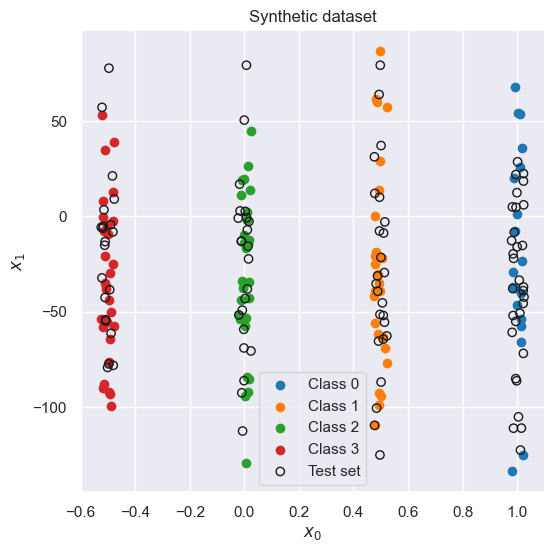

In [3]:
dataset_name = 'synth3'

# Load dataset splits
df_train = pd.read_csv(f"data/synth/{dataset_name}_train.csv")
df_test = pd.read_csv(f"data/synth/{dataset_name}_test.csv")

# Convert to numpy arrays
X_train = df_train[['x0', 'x1']].values
y_train = df_train['y'].values.astype(int)
X_test = df_test[['x0', 'x1']].values
y_test = df_test['y'].values.astype(int)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig = plt.figure(figsize=(6, 6))
for class_value in np.unique(y_train):
    # Create a mask for the current class
    mask = (y_train == class_value)
    # Plot training points
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {int(class_value)}', color=colors[int(class_value)])

# Plot the test points with a different marker (style)
plt.scatter(X_test[:, 0], X_test[:, 1], edgecolor='k', facecolors='none', label=f'Test set')
# Add labels and title
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

plt.title('Synthetic dataset')
plt.legend()
plt.show()

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # Note: use long for class labels
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)    # Note: use long for class labels

**Task 5.2:** Define a 1-layer neural network that is suitable for multinomial regression.

> *Hint:* Again, all we need to do is change the output activation in the `get_model` function.

> *Hint:* The softmax activation function is defined as `torch.nn.Softmax(dim=1)`. We specify `dim=1` - if we had used `dim=0`, the function would have
normalized not over classes but over the number of observations.

In [4]:
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),     # Input layer
        torch.nn.Tanh(),                                                                # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),    # Output layer
        torch.nn.Softmax(dim=1)                                                         # Output activation function (for multinomial classification)
    )

When doing multi-class classification, in addition to using the softmax as the output activation function, we also need to use the **cross entropy loss**.

**Task 5.3:** Implement the training loop to train a 1-layer neural network for classification with $5$ hidden units on the training data. Choose a suitable learning rate and number of epochs.

> *Hint:* Define the input and output dimensionality. What is the output dimensionality when we are classifying between 4 classes?

> *Hint:* The cross entropy loss is implemented as `torch.nn.CrossEntropyLoss()`.

> *Hint:* Compute the loss and accuracy for the training and test sets every epoch. Store the results like we did previously. We plot the results in the end of the cell.

> *Hint:* The `outputs` are the class probabilities. To get the predictions we can use `y_test_pred = torch.argmax(test_outputs, dim=1)`.

Epoch [1000/10000], Loss: 1.3202, Test Loss: 1.3508
Epoch [2000/10000], Loss: 1.3124, Test Loss: 1.3424
Epoch [3000/10000], Loss: 1.3498, Test Loss: 1.3792
Epoch [4000/10000], Loss: 1.1209, Test Loss: 1.1238
Epoch [5000/10000], Loss: 1.3507, Test Loss: 1.3682
Epoch [6000/10000], Loss: 1.3182, Test Loss: 1.2685
Epoch [7000/10000], Loss: 1.1679, Test Loss: 1.1248
Epoch [8000/10000], Loss: 1.2371, Test Loss: 1.2364
Epoch [9000/10000], Loss: 1.2438, Test Loss: 1.1539
Epoch [10000/10000], Loss: 1.0633, Test Loss: 1.0591


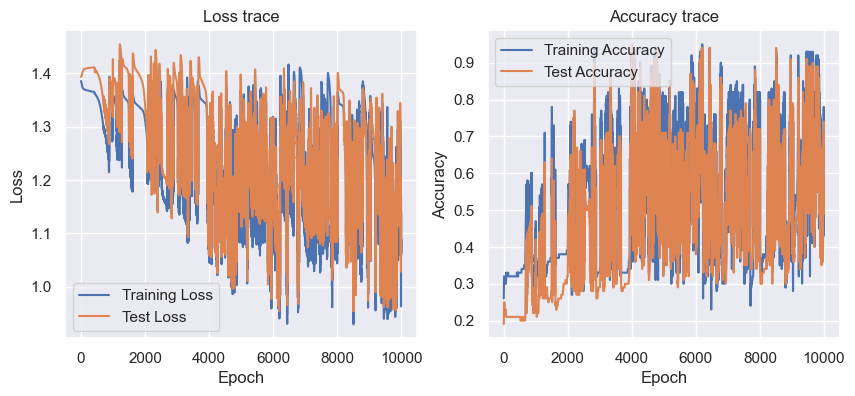

In [5]:
# Seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set up the model, criterion, optimizer, and results storage
# Define dimensionalities
input_dim  = 2 # 2 features
hidden_dim = 10
output_dim = 4 # 4 classes

# Define hyperparameters
n_epochs = 10000
lr = 1e-2

# Define a model instance with a specific number of hidden units
model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer as the Adam optimizer (not needed to know the details)
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

# Set up storage for results
results = {'train loss': [], 'test loss': [], 'train accuracy': [], 'test accuracy': []}
for epoch in range(n_epochs):
    # Implement the training loop here
    # Set the model to training mode
    model.train()

    # Make a forward pass through the model to compute the outputs
    outputs = model(X_train)
    # Compute the loss
    loss = criterion(outputs, y_train)

    # Make sure that the gradients are zero before you use backpropagation
    optimizer.zero_grad()
    # Do a backward pass to compute the gradients wrt. model parameters using backpropagation.
    loss.backward()
    # Update the model parameters by making the optimizer take a gradient descent step
    optimizer.step()

    # Store the training loss for this epoch in the dictionary
    results['train loss'].append(loss.item())

    # Compute the final test loss on the test set
    with torch.no_grad(): # No need to compute gradients for the validation set
        model.eval()
        # Compute the loss for the test set
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        # Store the test loss for this epoch in the dictionary
        results['test loss'].append(test_loss.item())

        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

        # Get the predictions as the class with the highest probability
        y_train_pred = torch.argmax(outputs, dim=1)
        y_test_pred = torch.argmax(test_outputs, dim=1)
        # Compute the accuracy on the training and test set
        train_accuracy = (y_train_pred == y_train).float().mean()
        test_accuracy = (y_test_pred == y_test).float().mean()
        # Store the accuracies in the dictionary
        results['train accuracy'].append(train_accuracy.item())
        results['test accuracy'].append(test_accuracy.item())

# Plot the optimization trace
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(results['train loss'], label='Training Loss')
axs[0].plot(results['test loss'], label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss trace')
axs[0].legend()

axs[1].plot(results['train accuracy'], label='Training Accuracy')
axs[1].plot(results['test accuracy'], label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy trace')
axs[1].legend()

plt.show()

 We plot the decision boundary below. 
 
 **Task 5.4:** Use the trained model to predict on the test data and plot the predictions on top of the decision boundary.

C:\Users\mrusn\AppData\Local\Temp\ipykernel_17684\1434399845.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx = np.arange(x_min, x_max, delta)
C:\Users\mrusn\AppData\Local\Temp\ipykernel_17684\1434399845.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  yy = np.arange(y_min, y_max, delta)


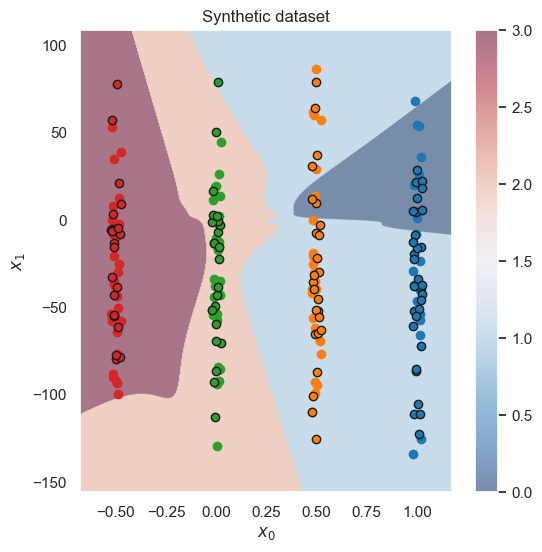

In [7]:
fig = plt.figure(figsize=(6, 6))
plot_decision_boundary(predict_function=lambda x: torch.argmax(model(x), dim=1), X=X_train, fig=fig)

for class_value in np.unique(y_train):
    # Create a mask for the current class
    mask = (y_train == class_value).flatten()
    # Plot training points
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {int(class_value)} (train)', color=colors[int(class_value)])

# PLOT THE PREDICTIONS HERE
# Loop over the unique predicted classes
for class_value in np.unique(y_test):
    # Create a mask for the current predicted class
    mask = (y_test == class_value).flatten()
    # Plot predicted test points
    plt.scatter(X_test[mask, 0], X_test[mask, 1], label=f'Class {int(class_value)} (test)', color=colors[int(class_value)], edgecolor='k')

# Add labels and title
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Synthetic dataset')
plt.show()

**Task 5.5:** Go back and re-run the experiment on the `synth2` dataset. What happens to the fit? Experiment with the learning rate and number of hidden units to find a good model.

**Task 5.6 (Optional):** Fit a multinomial regression model to the dataset. Plot the predictions, decision boundary and compare it to the neural network.

> *Hint:* Multinomial regression models are based on tieing the outputs by the softmax function. Especially consider the `synth3` dataset. Notice the multinomial regression model is able to solve this problem; look at the weights and explain how this is accomplished (n.b. notice the vertical dimension does not matter).

> *Hint:* Use `model = sklearn.linear_model.LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=0)` to define the model.

> *Hint:* Display coefficients by using `print(model.coef_)`.

Accuracy on test set: 100.00%
Optimal parameters found by logistic regression:
[[ 4.02191288e+00  1.71093064e-03]
 [ 1.33858862e+00  2.11473633e-04]
 [-9.98266275e-01 -4.32480606e-04]
 [-4.36223523e+00 -1.48992367e-03]]


C:\Users\mrusn\AppData\Local\Temp\ipykernel_17684\1434399845.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx = np.arange(x_min, x_max, delta)
C:\Users\mrusn\AppData\Local\Temp\ipykernel_17684\1434399845.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  yy = np.arange(y_min, y_max, delta)


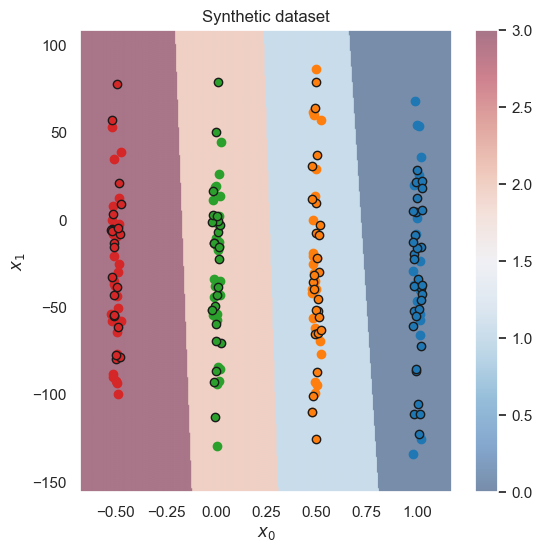

In [8]:
from sklearn.linear_model import LogisticRegression

# Multinomial logistic regression
model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(X_train, y_train)

# Number of miss-classifications
y_pred = model.predict(X_test)

# Compute accuracy
accuracy = (y_pred == y_test.numpy()).mean()
print(f'Accuracy on test set: {accuracy*100:.2f}%')

# Print the model parameters
print("Optimal parameters found by logistic regression:")
print(model.coef_)

# Plot the decision boundary
fig = plt.figure(figsize=(6, 6))
plot_decision_boundary(
    predict_function=lambda x: np.argmax(model.predict_proba(x), 1),  # prediction function
    X=X_train, 
    fig=fig
)

for class_value in np.unique(y_train):
    # Create a mask for the current class
    mask = (y_train == class_value).flatten()
    # Plot training points
    plt.scatter(X_train[mask, 0], X_train[mask, 1], label=f'Class {int(class_value)} (train)', color=colors[int(class_value)])

# Loop over the unique predicted classes
for class_value in np.unique(y_test):
    # Create a mask for the current predicted class
    mask = (y_test == class_value).flatten()
    # Plot predicted test points
    plt.scatter(X_test[mask, 0], X_test[mask, 1], label=f'Class {int(class_value)} (test)', color=colors[int(class_value)], edgecolor='k')

# Add labels and title
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Synthetic dataset')
plt.show()